In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
FEATURES_PREPPED_FILE = "features_prepped.csv"
TRAIN_TEST_SPLIT = 0.9
VAL_TEST_SPLIT = 0.9
START_DATE = datetime(2025,9,8) + timedelta(days=28)
BAD_FEATURES = []
TOP_100 = [2637208, 2674067, 2674069, 2677746, 2691590, 2739813, 2813189, 2813194, 2813195, 2819449, 2822887, 2840431, 2841189, 2855586, 2855595, 2857178, 3690505, 3690510, 4039724, 4189521, 4463773, 4580598, 5192206, 5192221, 5192225, 5245545, 5257669, 5658823, 5664444, 5683132, 5683135, 5683137, 5698506, 5698507, 5703921, 5710675, 5730396, 5823149, 5823150, 5850773, 5851707, 5955504, 5955510, 5955515, 5973485, 6049412, 6049413, 6256793, 6451779, 7210406, 7249979, 7379752, 7622814, 7622840, 7635753, 7653413, 7855462, 7869313, 7915951, 7917434, 7917436, 7922326, 8152638, 8152776, 8152803, 8152804, 8217944, 8422222, 8596633, 8858060, 8880222, 8966982, 8971859, 8972128, 9209729, 9245542, 9256674, 9603028, 9603030, 9603032, 9603035, 9656727, 9680118, 9724035, 10041062, 10041066, 10648067, 11061680, 11562016, 11562019, 12120522, 12168743, 12376820, 12376825, 12681178, 12744603, 13419273, 13536691, 14158330, 14234253]

In [3]:
df = pd.read_csv(FEATURES_PREPPED_FILE)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')
df = df[df['date'] >= START_DATE]
df

,date,universal_gemrate_id,spec_id,grade,half_grade,price,number_of_bids,seller_popularity,grade_co_BGS,grade_co_CGC,...,prev_5_below_grade_co_BGS,prev_5_below_grade_co_CGC,prev_5_below_grade_co_PSA,prev_5_below_seller_popularity,prev_5_below_days_ago,index_value,index_change_1d,index_change_1w,index_ema_12,index_ema_26
130674,2025-10-06,78dd24fe654dd5f6c074f7f03f8f0ac30d9afb33,8152770,10.0,0.0,10750,11,0.000000,0,0,...,0.0,0.0,1.0,0.967595,15.0,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
57423,2025-10-06,3007c94ad72c95fb73055f3befd746e5c0b76c33,12376810,10.0,1.0,8500,22,0.925908,0,1,...,0.0,0.0,1.0,0.008854,13.0,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
268223,2025-10-06,ffb8699bb7f435eff4e9761f8e29358e351d777e,544027,7.0,1.0,36004,13,0.925664,0,1,...,0.0,1.0,0.0,0.943491,7.0,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
171303,2025-10-06,a18c15bfb7deae2dcac55badf5f46991a1400e4d,13676648,10.0,0.0,20950,15,0.925745,0,0,...,NaN,NaN,NaN,NaN,NaN,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
43158,2025-10-06,1fe6084c2d1eab90bcb6792be67044a6da1e40b9,7038506,10.0,0.0,1350,15,0.000138,0,1,...,NaN,NaN,NaN,NaN,NaN,1201.636921,-10.623538,-17.701331,1194.448714,1145.579525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48196,2025-12-17,2618f36ec1473935d60380a8de67be9c4b20eed8,544047,4.0,0.0,3100,5,0.223115,0,0,...,NaN,NaN,NaN,NaN,NaN,1041.392920,-5.345614,7.294305,1045.237297,1057.132354
53820,2025-12-17,2cc49de9ef33d0710167f1c1e3b8b11107a5f055,9875042,10.0,0.0,11103,14,0.223106,0,0,...,0.0,0.0,1.0,0.162048,41.0,1041.392920,-5.345614,7.294305,1045.237297,1057.132354
51064,2025-12-17,298669bd9e8b6ba3c10fde17edc1e46223a8be83,544484,10.0,0.0,14650,28,0.000019,0,1,...,NaN,NaN,NaN,NaN,NaN,1041.392920,-5.345614,7.294305,1045.237297,1057.132354
54711,2025-12-17,2de168406c7c8944d9c321ce84dbd2be7a64f6cd,544167,8.0,0.0,4000,23,0.000000,0,1,...,NaN,NaN,NaN,NaN,NaN,1041.392920,-5.345614,7.294305,1045.237297,1057.132354


In [4]:
feature_cols = [col for col in df.columns if col not in ['universal_gemrate_id', 'spec_id', 'date', 'price'] and col not in BAD_FEATURES]
feature_cols

['grade',
 'half_grade',
 'number_of_bids',
 'seller_popularity',
 'grade_co_BGS',
 'grade_co_CGC',
 'grade_co_PSA',
 'prev_1_price',
 'prev_1_half_grade',
 'prev_1_grade_co_BGS',
 'prev_1_grade_co_CGC',
 'prev_1_grade_co_PSA',
 'prev_1_days_ago',
 'prev_2_price',
 'prev_2_half_grade',
 'prev_2_grade_co_BGS',
 'prev_2_grade_co_CGC',
 'prev_2_grade_co_PSA',
 'prev_2_days_ago',
 'prev_3_price',
 'prev_3_half_grade',
 'prev_3_grade_co_BGS',
 'prev_3_grade_co_CGC',
 'prev_3_grade_co_PSA',
 'prev_3_days_ago',
 'prev_4_price',
 'prev_4_half_grade',
 'prev_4_grade_co_BGS',
 'prev_4_grade_co_CGC',
 'prev_4_grade_co_PSA',
 'prev_4_days_ago',
 'prev_5_price',
 'prev_5_half_grade',
 'prev_5_grade_co_BGS',
 'prev_5_grade_co_CGC',
 'prev_5_grade_co_PSA',
 'prev_5_days_ago',
 'avg_price_1w_ago',
 'avg_half_grade_1w_ago',
 'avg_seller_popularity_1w_ago',
 'avg_grade_co_BGS_1w_ago',
 'avg_grade_co_CGC_1w_ago',
 'avg_grade_co_PSA_1w_ago',
 'avg_price_2w_ago',
 'avg_half_grade_2w_ago',
 'avg_seller_popu

In [5]:
train_df = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT)]
test_df = df.iloc[int(len(df) * TRAIN_TEST_SPLIT):]
val_df = test_df.iloc[:int(len(test_df) * VAL_TEST_SPLIT)]
test_df = test_df.iloc[int(len(test_df) * VAL_TEST_SPLIT):]

# val_df = val_df.loc[val_df["spec_id"].isin(TOP_100)]
# test_df = test_df.loc[test_df["spec_id"].isin(TOP_100)]


In [6]:
val_df["date"].min()

Timestamp('2025-12-01 00:00:00')

In [7]:
X_train = train_df[feature_cols].copy()
y_train = train_df['price'].copy()
y_train = np.log(train_df['price'].copy())

X_val = val_df[feature_cols].copy()
y_val = val_df['price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['price'].copy()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Number of features: {len(feature_cols)}")


Training set: 132701 samples
Validation set: 13270 samples
Number of features: 136


In [8]:
model = XGBRegressor(device='cuda')

# Define parameter grid
param_grid = {
    'max_depth': [10],
    'learning_rate': [0.075],
    'n_estimators': [150],
    'min_child_weight': [30],
    'subsample': [0.9],
    'colsample_bytree': [1.0],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [5],
    'colsample_bylevel': [0.7],
    'max_delta_step': [0],
}

best_score = 99999
best_grid = {}
for g in ParameterGrid(param_grid):
    model.set_params(**g)
    model.fit(X_train,y_train)
    y_val_pred = model.predict(X_val)
    y_val_pred = np.exp(y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"MAPE: {mape:.2%}")
    if mape < best_score:
        best_score = mape
        best_grid = g
    print(f"Best MAPE: {best_score:.2%}")

print ("Best MAPE: %0.5f" % best_score )
print ("Best Grid:", best_grid)

MAPE: 21.56%
Best MAPE: 21.56%
Best MAPE: 0.21563
Best Grid: {'colsample_bylevel': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.075, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 30, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.9}


/root/sync/ava/collector_crypt/.venv/lib/python3.13/site-packages/xgboost/core.py:774: UserWarning: [10:17:28] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [9]:
best_model = XGBRegressor(device='cuda')
best_model.set_params(**best_grid)
best_model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.7
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [10]:
y_val_pred = best_model.predict(X_val)
y_val_pred = np.exp(y_val_pred)

val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

simple_percent_error = (np.abs(X_val["prev_1_price"].values - y_val.values) / y_val.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_val_pred - y_val.values) / y_val.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Validation Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

Validation Metrics:
  RMSE: $41,364.25
  MAE:  $6,616.55
  MAPE: 21.56%
  R²:   0.7840

Simple Percent Error Percentiles:
count    12477.000000
mean        30.216090
std         85.080855
min          0.000000
10%          1.886792
20%          4.123711
30%          7.142857
40%         10.588235
50%         14.634146
60%         19.607843
70%         26.865672
80%         38.461538
90%         61.718112
max       4100.040000
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    13270.000000
mean        21.562779
std         56.230354
min          0.000035
10%          2.010014
20%          4.070327
30%          6.423073
40%          8.976884
50%         12.057134
60%         15.917866
70%         20.921772
80%         28.879521
90%         43.878892
max       4081.006875
Name: percent_error, dtype: float64


In [11]:
y_test_pred = best_model.predict(X_test)
y_test_pred = np.exp(y_test_pred)

val_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_mae = mean_absolute_error(y_test, y_test_pred)
val_mape = mean_absolute_percentage_error(y_test, y_test_pred)
val_r2 = r2_score(y_test, y_test_pred)

simple_percent_error = (np.abs(X_test["prev_1_price"].values - y_test.values) / y_test.values) * 100
simple_percent_error_series = pd.Series(simple_percent_error, name='simple_percent_error')
percent_error = (np.abs(y_test_pred - y_test.values) / y_test.values) * 100
percent_error_series = pd.Series(percent_error, name='percent_error')

print("Test Metrics:")
print(f"  RMSE: ${val_rmse:,.2f}")
print(f"  MAE:  ${val_mae:,.2f}")
print(f"  MAPE: {val_mape:.2%}")
print(f"  R²:   {val_r2:.4f}")

print("\nSimple Percent Error Percentiles:")
print(simple_percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

print("\nPercent Error Percentiles:")
print(percent_error_series.describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))


Test Metrics:
  RMSE: $20,322.88
  MAE:  $4,801.57
  MAPE: 24.54%
  R²:   0.8896

Simple Percent Error Percentiles:
count    1380.000000
mean       35.519639
std        74.598020
min         0.000000
10%         1.958410
20%         4.402278
30%         7.949703
40%        11.745692
50%        16.051655
60%        22.428764
70%        30.202200
80%        45.088596
90%        69.270322
max      1375.777778
Name: simple_percent_error, dtype: float64

Percent Error Percentiles:
count    1475.000000
mean       24.539779
std        42.811153
min         0.002223
10%         2.228324
20%         4.231432
30%         7.008042
40%         9.637770
50%        12.916796
60%        16.698466
70%        23.919012
80%        32.044687
90%        51.959896
max       583.492737
Name: percent_error, dtype: float64


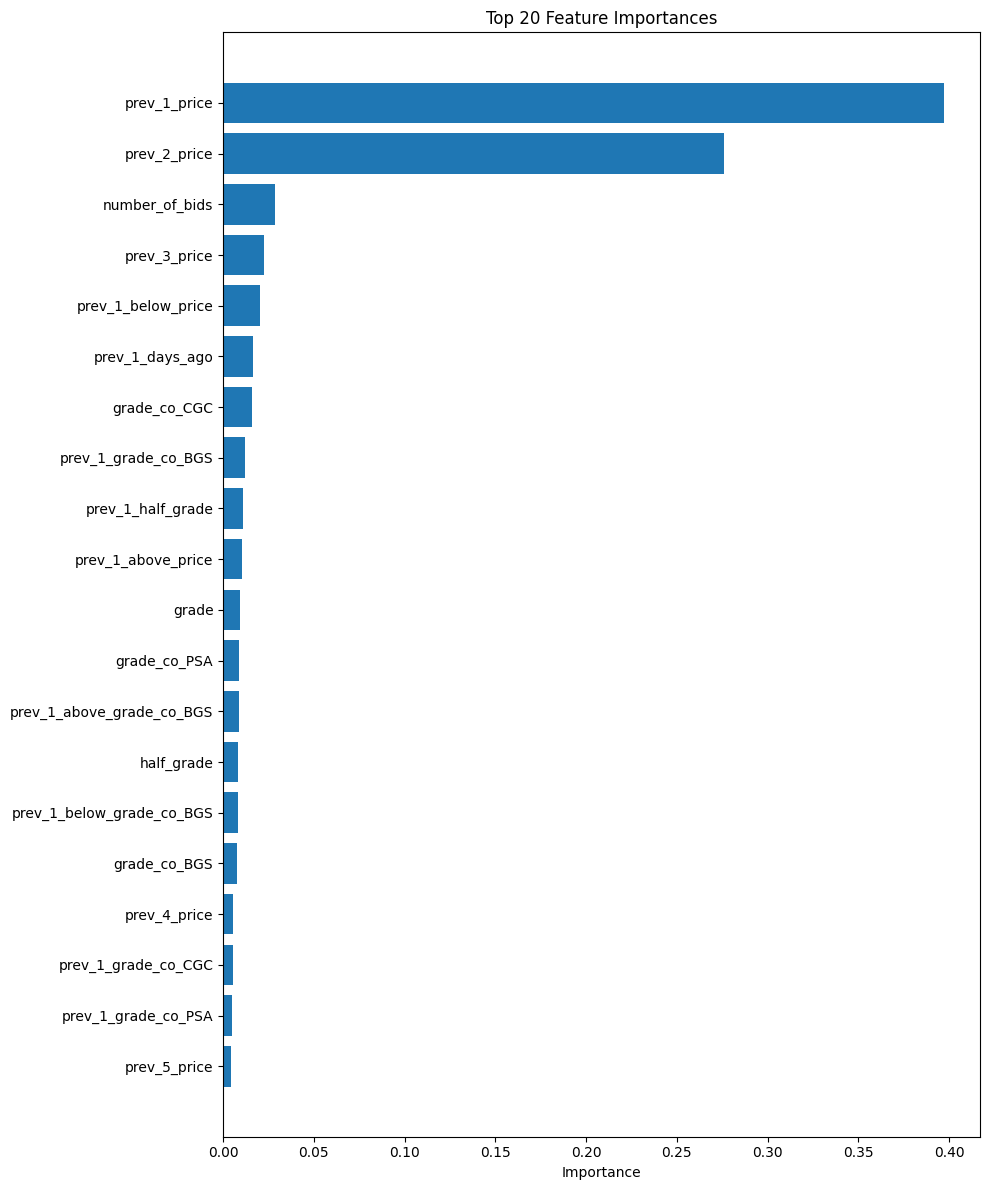

In [12]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head(20)
importance_df["importance_cumsum"] = importance_df["importance"].cumsum()

In [13]:
importance_df
bad_features = importance_df[importance_df["importance_cumsum"] > 0.95]["feature"]
list(bad_features)

['prev_1_below_days_ago',
 'prev_5_grade_co_CGC',
 'prev_5_above_price',
 'prev_5_below_grade_co_PSA',
 'prev_3_days_ago',
 'prev_5_grade_co_PSA',
 'prev_2_grade_co_BGS',
 'prev_2_below_days_ago',
 'avg_grade_co_CGC_1w_ago',
 'prev_2_half_grade',
 'prev_2_above_grade_co_CGC',
 'prev_3_below_days_ago',
 'prev_1_below_seller_popularity',
 'prev_3_above_grade_co_PSA',
 'prev_5_below_grade_co_CGC',
 'prev_2_below_grade_co_BGS',
 'avg_grade_co_CGC_2w_ago',
 'prev_3_half_grade',
 'prev_4_below_days_ago',
 'prev_3_above_grade_co_CGC',
 'avg_grade_co_BGS_4w_ago',
 'avg_grade_co_PSA_2w_ago',
 'prev_5_half_grade',
 'avg_grade_co_PSA_1w_ago',
 'prev_5_below_days_ago',
 'prev_3_below_grade_co_PSA',
 'avg_grade_co_CGC_3w_ago',
 'prev_4_below_half_grade',
 'prev_3_above_days_ago',
 'prev_5_above_days_ago',
 'prev_3_above_seller_popularity',
 'prev_5_below_grade_co_BGS',
 'avg_grade_co_PSA_3w_ago',
 'prev_2_above_seller_popularity',
 'avg_half_grade_4w_ago',
 'avg_grade_co_CGC_4w_ago',
 'prev_4_half_